In [1]:
import os

# load some python visualization and mathematics packages
import matplotlib
import nibabel as nib
import numpy as np
import skimage
import ipywidgets as widgets
from matplotlib import pyplot as plt

from pprint import pprint
from ipywidgets import interact, interactive, Layout, HBox
from skimage.transform import rescale, warp, ProjectiveTransform

# DCAN Lab Introduction to Image Mathematics

This is written as introductory material to the mathematics of images for neuroscientists and psychologists interested in neuroimaging. It covers some basic terminology, image arithmetic, as well as some more advanced topics relevant to medical imaging.


## Topics

* What makes an image?


* What are some operations on images?

    * Images and Numbers

    * Images and other Images
    
    * Masking and Segmentation
    
    * Transformations


* What kind of images are there in MRI research?

    * Anatomical
    
    * Functional
    
    * Field Maps
    
    * DWI


* Common MRI Processing Tools

    * fsl
    
    * FreeSurfer
       
    * ANTs
    
    * Workbench Command
    

## Interactive Setup

If you wish to use this notebook interactively, there are a number of python packages you will need to install first. 
The very fist cell contains all of the import statements necessary.
Install anaconda or setup a virtual environment, and ensure that all packages in the `requirements.txt` file are installed.


# What Makes An Image?

In this context we will always be talking about *digital images*, the way that they are represented on a computer. Starting with 2-dimensional images, a standard digital image is represented on a computer by a `grid` or `matrix` of numbers.

If you are new to Jupyter notebooks such as this one, the off-white boxes such as the one below, with `In [N]:` (where N is some number) in the margins, are the python code used to display images/examples.  The code may be followed or ignored for the purposes of this introduction, depending on your interest in python/programming.


In [2]:
# intialize a grid, we will call it "grid1"
m = 6; n = 6
grid1 = np.zeros((m, n), dtype=int)
grid1[:, :n//2] = 1

# initialize a second grid, "grid2"
m = 3; n = 3
even = np.array(m * [1, 0])
odd = even[::-1]
grid2 = np.row_stack(n * (even, odd))

# print the grids out as data/matrices
pprint(grid1.tolist())
print('')
pprint(grid2.tolist())

[[1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0]]

[[1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1],
 [1, 0, 1, 0, 1, 0],
 [0, 1, 0, 1, 0, 1]]


Above you can see the grids we have created, which we will call `grid1` and `grid2`. Notice grid1 is split half and half between 1 and 0, grid2 is alternating 1s and 0s.

Above are text representations of numpy arrays, they basically follow the shape of their corresponding matrices, which we'll see below.

What you see is organized by two indices: a row index and a column index which together map each element.

Typically, we use the index variables `i` and `j` as subscripts to correspond to rows and columns respectively.  

For a matrix, $A$, we use $a_{ij}$ to represent each individual value in the matrix (commas are generally omitted in single-digit cases):

$$\begin{bmatrix}a_{1,1} & a_{1,2} & a_{1,3} & a_{1,4} & a_{1,5} & a_{1,6}\\a_{2,1} & a_{2,2} & a_{2,3} & a_{2,4} & a_{2,5} & a_{2,6}\\a_{3,1} & a_{3,2} & a_{3,3} & a_{3,4} & a_{3,5} & a_{3,6}\\a_{4,1} & a_{4,2} & a_{4,3} & a_{4,4} & a_{4,5} & a_{4,6}\\a_{5,1} & a_{5,2} & a_{5,3} & a_{5,4} & a_{5,5} & a_{5,6}\\a_{6,1} & a_{6,2} & a_{6,3} & a_{6,4} & a_{6,5} & a_{6,6}\end{bmatrix}$$

In grid above, the $a_{ij}$ variables corresponds to the real valued numbers in the grids below:

$$\begin{bmatrix}1 & 1 & 1 & 0 & 0 & 0\\1 & 1 & 1 & 0 & 0 & 0\\1 & 1 & 1 & 0 & 0 & 0\\1 & 1 & 1 & 0 & 0 & 0\\1 & 1 & 1 & 0 & 0 & 0\\1 & 1 & 1 & 0 & 0 & 0\end{bmatrix} \quad \begin{bmatrix}1 & 0 & 1 & 0 & 1 & 0\\0 & 1 & 0 & 1 & 0 & 1\\1 & 0 & 1 & 0 & 1 & 0\\0 & 1 & 0 & 1 & 0 & 1\\1 & 0 & 1 & 0 & 1 & 0\\0 & 1 & 0 & 1 & 0 & 1\end{bmatrix}$$

Both images and matrices are grids of points (or pixels), so we can use this same notation for images.

Let's see how these matrices look as a images:

Text(0.5, 1.0, 'grid2')

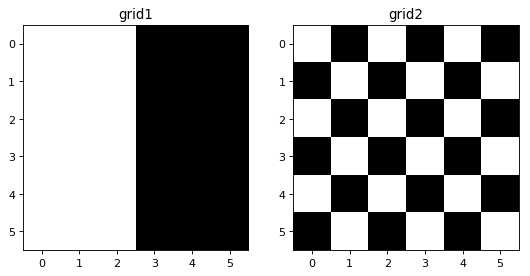

In [3]:
if not matplotlib.get_backend() == 'Qt5Agg':
    try:
        matplotlib.use('Qt5Agg')  # for faster plotting if its there
    except:
        pass
%matplotlib inline

fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(grid1, cmap='gray')
plt.title('grid1')
plt.subplot(1, 2, 2)
plt.imshow(grid2, cmap='gray')
plt.title('grid2')

Notice that wherever we had a 1, the image shows a white square.  Wherever we had a 0, the image shows a black square.  Whether the number or the visible representation, these are `pixels`.

If we were discussing photographs such as taken on a digital camera, each pixel would actually have three values associated: R, G, and B.  In the context of MRI, we are usually only concerned with `grayscale images` (colloquially, black and white images).

The images above, which only have two values: 0, and 1, are a special case of greyscale image, known as a `binary image`


# What Are Some Operations on Images?

Here we will discuss mathematical operations which can be performed on images.

### Images and Numbers

Given some number $x$, and another number $a$, I can write some simple equations like:

$$
x + a = 5 \\
x - a = 1 \\
x \times a = 6 \\
x ^ a = 9
$$

Which you will recognize as addition, subtraction, multiplication and exponentiation.

For some image $I$, and a number $a$, I can carry out all of the same operations, for example, I can add $a$ to grid1 (the half-and-half grid from before):

$$ I + a = ?$$

As it turns out, the extension is quite simple.


In [18]:
# set our image I as the first grid
I = grid1

# add 2 to the image to get a new image, J.
J = I + 2

pprint(I.tolist())
print('')
pprint(J.tolist())

[[1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0],
 [1, 1, 1, 0, 0, 0]]

[[3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2],
 [3, 3, 3, 2, 2, 2]]


Notice that the value of each element in grid1 has increased by 2!  We call these *elementwise* operations, where the normal mathematical operation: addition, multiplication, etc. is carried out individually on each pixel/element of the image:

$$ J_{n, m} = a + I_{n, m} $$

where $I_{n, m}$ is the element in row n, column m, of $I$ 

Adding 2 to an image is the same as adding 2 to every pixel, multiplying an image by 2 is the same as multiplying every pixel by 2.  In fact, even fancy operations like log, exponents, or trig functions obey this same rule.

Let's take a look at the visual result for illustrative purposes:

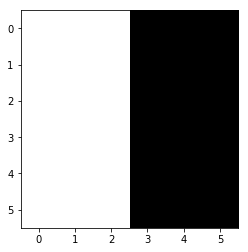

In [5]:
plt.imshow(J, cmap='gray')

##### Question:  Why does the image still look the same as before?

...

Answer: You must be careful when visually comparing different images to make sure they are *scaled* the same. 2 is here black because it is the *lowest* value in the image.  3 is white because it is the *highest*.  We could also scale this image from 0 to 4, and we would see some slightly different shades of gray in place of 3 and 2:

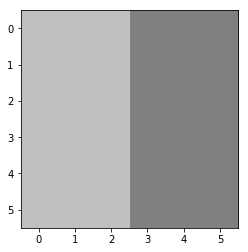

In [6]:
plt.imshow(J, cmap='gray', vmin=0, vmax=4)

## Images and other Images

Similar to before, we can also have addition, subtraction, multiplication, division, etc. between images.  For example, given an image $I$ and an image $J$ we can still have:  

$I + J = K$

where K is a new image.  To perform this operation, we *add* I and J elementwise, like so:

$$ K_{n,m} = I_{n,m} + J_{n,m} $$

Here we will add the two images from above, the checkered and the half and half:

[[2, 1, 2, 0, 1, 0],
 [1, 2, 1, 1, 0, 1],
 [2, 1, 2, 0, 1, 0],
 [1, 2, 1, 1, 0, 1],
 [2, 1, 2, 0, 1, 0],
 [1, 2, 1, 1, 0, 1]]


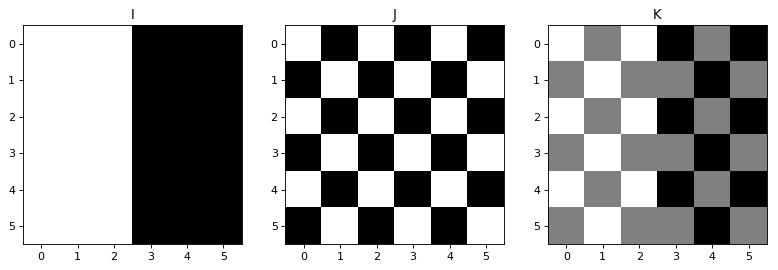

In [7]:
I = grid1; J = grid2
K = I + J
pprint(K.tolist())


def plot_ijk(I, J, K, vm=None):
    fig = plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')
    for i, splt in enumerate(zip(('I', 'J', 'K'), [I, J, K])):
        plt.subplot(1, 3, i + 1)
        if vm:
            plt.imshow(splt[1], vmin=vm[0], vmax=vm[1], cmap='gray')
        else:
            plt.imshow(splt[1], cmap='gray')
        plt.title(splt[0])

plot_ijk(I, J, K)

Note that there are now three distinct values in the matrix: 2, 1, 0, and three distinct `gray levels` in the resulting image on the right.

#### Try it for yourself!

Code cells can be run by hitting `[Shift] + [ENTER]`

I'm going to modify the code a bit here, the visual minimum and maximum will be whatever the min and max of I, J, and K are together.

<Figure size 960x880 with 0 Axes>

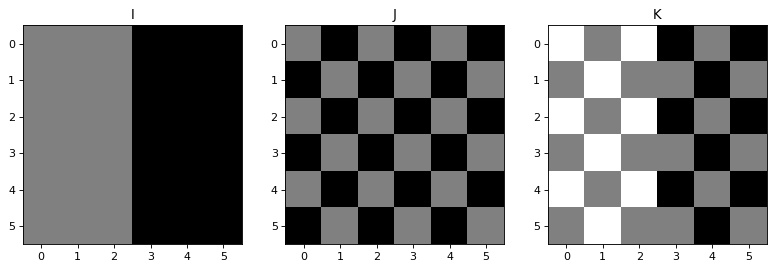

In [8]:
# modify the line below for whatever calculation you want to see
K = I + J

fig=plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')
mx = np.concatenate((I, J, K)).flatten().max()
mn = np.concatenate((I, J, K)).flatten().min()
plot_ijk(I, J, K, vm=(mn, mx))

#### Some Real Images

okay, so that's all well and good but these images are kind of boring, let's spice it up.

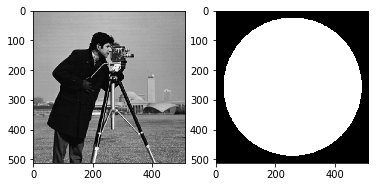

In [9]:
camera = skimage.data.camera()
l_x, l_y = camera.shape[0], camera.shape[1]
X, Y = np.ogrid[:l_x, :l_y]
outer_disk_mask = (X - l_x / 2)**2 + (Y - l_y / 2)**2 < ((l_x - 50) / 2)**2

plt.subplot(1, 2, 1)
plt.imshow(camera, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(outer_disk_mask, cmap='gray')

Let's see what happens when we multiply these two together!

In the cell below, write the equation for multiplying the images in place of the `None`, then hit `[Shift] + [Enter]` to run the code.

`Note: For interactive use of this notebook, you will need to set up a proper environment with all of the required packages.`

In [10]:
# replace "None" with your equation, the variables available are "camera", 
# for the photograph, and "outer_disk_mask", for the white circle
# you may need to select "Kernel" and hit "Restart and run all" first.
product = None

if product is not None:
    plot_ijk(camera, outer_disk_mask, product)
else:
    print('product has not been assigned')

product has not been assigned


## Transformations

Now we will start to get into the idea of transforming an image.  Transformations are what allow us to register images.  

### Linear Transformations

There are 4 aspects of linear transformation:

* Translation

* Rotation

* Scaling

* Shearing

##### Affine Linear Transforms

Below is an illustration of each of the 4, sometimes known by slightly different names.  Here "Shearing" is "Skew", and "Differential" Scaling is used because the scaling need not be equivilent in different dimentions (hence the differential), turning the square into a rectangle.

![the 4 types of affine transformation](img/all_4_affine.jpg)

Together these 4 transformation types make up "affine" transformations.  A single linear transformation may involve one, or all of them.  It is specifically called 'affine' when we are using or allowed to use all 4. 

*Affine transformations are the set of continuous transformations which preserve parallel lines*.  It is helpful to visualize a square when thinking about these transforms, because it beautifully illustrates the different possibilities:  Any transformation of a square into a rectangle or rhombus is permitted through skew and scaling, but trapezoids and other quadrilaterals would not be possible, as it would break the parallelism.

When you hear the term `degrees of freedom` used in the context of affine transformations, it corresponds to the parameters which dictate these 4 types of transforms.  

By constraining certain parameters, we can get a special classes of linear transformation:

##### Rigid Body Linear Transforms

Translation and rotation, when considered alone, encompass `rigid body` or `euclidean` transformations.  A translation is a shift of the object from point A to point B.  A rotation is performed about the origin.  Transformations involving only these two aspects are called "rigid body", because the shape and size of the object are constant through these transforms.

Below you can use the sliders to play with the translation and rotation.  Notice what happens to the edges of the square as it moves through discrete pixels in the image's field of view.


In [12]:
N = 64
square = np.zeros((N, N))
square[N//2-5:N//2+6, N//2-5:N//2+6] = 1

fig = plt.figure()
def f(tx, ty, θ, interp=None):
    if interp:
        interp = 0
    else:
        interp = 1
    θ = θ / 180 * np.pi
    global square
    mat = np.array([
        [np.cos(θ), -np.sin(θ), tx],
        [np.sin(θ), np.cos(θ), ty],
        [0, 0, 1] # rigid body
    ])
    img = warp(square, mat, output_shape=square.shape, order=interp)
    ax = plt.imshow(img, cmap='gray')
    ax2 = plt.grid()

x = widgets.IntSlider(min=-32, max=32, step=2)
y = widgets.IntSlider(min=-32, max=32, step=2)
t = widgets.IntSlider(min=-50, max=50, step=10)
interpolation = widgets.Checkbox(
    value=False,
    description='Nearest Neighbor',
    disabled=False
)

<Figure size 432x288 with 0 Axes>

In [13]:
plot = interactive(f, tx=x, ty=y, θ=t, interp=interpolation)
display(plot)

interactive(children=(IntSlider(value=0, description='tx', max=32, min=-32, step=2), IntSlider(value=0, descri…

You may notice a couple of things here:

1. the translation tx and ty are inverted 

      *this is akin to shifting algebraic functions f(x) to the left or right on a graph.*


2. the origin is in the top-left instead of the bottom-left

    *this is how image coordinates differ from cartesian coordinates.*


3. the square rotates about the origin, not its own center of mass.

    *This is because the transformation is on the entire coordinate system. If there were two objects, they would both be transformed according to the coordinate transform.*

In order to flip an object upside down, you need to rotate it 180 degrees about the origin, then translate it back across (twice its starting distance from $(0,0)$.  Later, when we get into MRI images we will talk about sform and qform, and why they help with this process.

You should also note that the edges blur as the square moves around in space.  This is because the edges of the square do not land neatly into a single pixel.


#### Interpolation

##### Bi-Linear
The default option on this interactive widget, where the blurring is observed, is called "Bi-Linear" interpolation.  New pixels are filled in with the average value of the pixels around them.  That way we get a sense of where the square has 'mostly' entered a pixel, or 'slightly' entered a pixel by the resulting darker fade.


##### Nearest Neighbor
One option would be a sort of "majority vote":  any pixel which is closer to a square edge than empty space gets filled in.  Click the "Nearest Neighbor" box to see this in action.  You can see how the shape can lose its squarish form with this method.  To begin with, the square is intensity 1 and the background is 0.  For the faded pixels from before, any with a value less than .5 become 0 and any greater than .5 become 1.

Q: Why use Nearest Neighbor if the result can be so mishapen?

A: It is primarily useful when dealing with labeled data.  If the square/object is a box dileaneating someone's hippocampus, faded values may not have any discernable meaning.  Furthermore, the faded values less than .5 are actually mostly "not square", so depending on how specific we want to be, it may be important to not include those points.


#### Interactive Affine Transformations


Below, I will allow you to play with affine transformations.  You now have an additional 4 parameters to play with while moving the image.  See what they do!

(hint:  $k_x$ and $k_y$ may appear to do nothing at first, but try playing with $\theta$ as well!)

If the square gets lost, press the reset button.

In [20]:
N = 128
square2 = np.zeros((N, N))
square2[60:100, 60:100] = 1
horse = rescale(skimage.data.horse(), .25, anti_aliasing=True, multichannel=False)
coffee = rescale(skimage.data.coffee(), .25, anti_aliasing=True, multichannel=True)

def f(tx, ty, θ, kx, ky, sx, sy, interp=None, image='square'):
    if interp:
        interp = 0
    else:
        interp = 1
    θ =  θ / 180 * np.pi
    mat = np.array([
        [sx * np.cos(θ), ky * -np.sin(θ), tx],
        [kx * np.sin(θ), sy * np.cos(θ), ty],
        [0, 0, 1] # rigid body
    ])
    if image == 'square':
        global square2
        image = square2
        cmap = 'gray'
    elif image == 'horse':
        image = horse
        dims = image.shape
        cmap = 'gray'
    elif image == 'coffee':
        image = coffee
        cmap = 'RGB'
    xdim = image.shape[1]
    ydim = image.shape[0]
    shiftR = np.array([
            [1, 0, -xdim],
            [0, 1, -ydim],
            [0, 0, 1] # rigid body
        ])
    shiftL = np.array([
            [1, 0, xdim/2],
            [0, 1, ydim/2],
            [0, 0, 1] # rigid body
        ])
    mat = shiftL @ mat @ shiftR
    
    img = warp(image, mat, output_shape=([2*x for x in image.shape]), 
               order=interp, mode='constant')
    if cmap != 'RGB':
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.grid()

def reset_values(b):
    for child in plot2.children:
        if not hasattr(child, 'description'):
            continue
        elif child.description in ['tx', 'ty', 'θ']:
            child.value = 0
        elif child.description in ['sx', 'sy', 'kx', 'ky']:
            child.value = 1.0

reset_button = widgets.Button(description = "Reset")
reset_button.on_click(reset_values)

x2 = widgets.IntSlider(min=-200, max=200, step=10, orientation='vertical')
y2 = widgets.IntSlider(min=-200, max=200, step=10, orientation='vertical')
t2 = widgets.IntSlider(min=-180, max=180, step=18, orientation='vertical')
kx = widgets.FloatSlider(min=-.5, max=2.0, value=1, orientation='vertical')
ky = widgets.FloatSlider(min=-.5, max=2.0, value=1, orientation='vertical')
sx = widgets.FloatSlider(min=0, max=2.0, value=1, orientation='vertical')
sy = widgets.FloatSlider(min=0, max=2.0, value=1, orientation='vertical')
interpolation = widgets.Checkbox(
    value=False,
    description='Nearest Neighbor',
    disabled=False
)
images = widgets.RadioButtons(options=['square', 'horse', 'coffee'])
plot2 = interactive(f, tx=x2, ty=y2, θ=t2, kx=kx, ky=ky, sx=sx, sy=sy, interp=interpolation, image=images)
layout = Layout(display='flex', flex_flow='row', justify_content='space-between', alight_items='center')

/home/euler/anaconda3/envs/swissknife/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [16]:
plot2.update()
display(HBox([plot2.children[-1], images]))
display(HBox([*plot2.children[:-2], reset_button], layout=layout))

### 3 dimensional images (MRI)

without further ado, let's take a look at these same concepts on 3 dimensional brains! The concepts of affine transformations generalizes nicely here. In fact, you probably have more of an intuitive grasp of them, as your mind is perfectly suited to modeling 3D transformations.

The only trouble is that it can be somewhat tedious to constantly *visualize* what the computer is doing. A lot of neuroscience researchers use a lot of transformation tools such as `fsl flirt` without a good intuition for the *rules* of what its doing. By playing with some of it interactively, we might get a better intuition for how they work, and what they're good for.

Now, remember **rigid body transformations**? Let's revisit them on an MRI image.  Bear with me for a second, this will take a little bit of code to setup...

In [46]:
# download an open source MR image.
import requests
from tdqm import tdqm
t1w = 'sub-01_T1w.nii.gz'
if not os.path.exists(t1w):
    url = 'https://openneuro.org/crn/datasets/ds001131/snapshots/00004/files/sub-01:anat:%s' % t1w
    r = requests.get(url, stream=True)
    print('downloading t1w image...')
    with open(t1w, 'wb') as fd:
        for content in tqdm(r.iter_content()):
            fd.write(content)
lazy_anat_img = nib.load('sub-01_T1w.nii.gz')

In [95]:
from scipy.ndimage import affine_transform

# downsample the image for plotting speed.
anat_img = rescale(lazy_anat_img.get_fdata(), 
                   .5, multichannel=False, mode='constant', anti_aliasing=True, order=3)

# some variables we'll use later
xmid = anat_img.shape[0] // 2 
ymid = anat_img.shape[1] // 2
zmid = anat_img.shape[2] // 2
interp_dict = dict(
    [(y, x) for x, y in enumerate(['Nearest Neighbor', 'Linear', 'Quadratic', 'Cubic'])]
)

def f(tx, ty, tz, α, γ, β, interp=None):
    """
    plot 3 slices of MR image using homogenous transform,
    euler angles γ, β are switched in the interactive plot, due to the image orientation.
    """
    interp = interp_dict[interp]  # skimage uses integer codes for interpolation.
    fig = plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')
    α = α / 180 * np.pi
    β = β / 180 * np.pi
    γ = γ / 180 * np.pi
    global anat_img
    shiftR = np.array([
            [1, 0, 0, -xmid],
            [0, 1, 0, -ymid],
            [0, 0, 1, -zmid],
            [0, 0, 0, 1]
        ])
    shiftL = np.array([
            [1, 0, 0, xmid],
            [0, 1, 0, ymid],
            [0, 0, 1, zmid],
            [0, 0, 0, 1]
        ])
    mat = np.array([
        [np.cos(α) * np.cos(β), np.cos(α) * np.sin(β) * np.sin(γ) - np.sin(α) * np.cos(γ), 
         np.cos(α) * np.sin(β) * np.cos(γ) + np.sin(α) * np.sin(γ), tx],
        [np.sin(α) * np.cos(β), np.sin(α) * np.sin(β) * np.sin(γ) + np.cos(α) * np.cos(γ), 
         np.sin(α) * np.sin(β) * np.cos(γ) - np.cos(α) * np.sin(γ), ty],
        [-np.sin(β), np.cos(β) * np.sin(γ), np.cos(β) * np.cos(γ), tz],
        [0, 0, 0, 1]
    ])
    # rotate image about its midpoint, not the origin...
    mat = shiftL @ mat @ shiftR
    img = affine_transform(anat_img, mat, output_shape=anat_img.shape, order=interp)
    # plot 3 slices
    plt.subplot(1, 3, 1)
    ax = plt.imshow(img[xmid, :, ::-1].T, cmap='gray')
    ax2 = plt.grid()
    t = plt.title('saggital')
    plt.subplot(1, 3, 2)
    ax = plt.imshow(img[:, ymid, ::-1].T, cmap='gray')
    ax2 = plt.grid()
    t = plt.title('coronal')
    plt.subplot(1, 3, 3)
    ax = plt.imshow(img[:, :, zmid].T, cmap='gray')
    ax2 = plt.grid()
    t = plt.title('axial')

def reset_values(b):
    for child in plot3.children:
        if not hasattr(child, 'description'):
            continue
        elif child.description in ['tx', 'ty', 'tz', 
                                   '(yaw) α', '(pitch) β', 
                                   '(roll) γ']:
            child.value = 0
        elif child.description in ['interpolation']:
            child.value = 'Linear'

reset_button2 = widgets.Button(description = "Reset")
reset_button2.on_click(reset_values)

x3 = widgets.FloatSlider(min=-32, max=32, step=0.5, orientation='vertical')
y3 = widgets.FloatSlider(min=-32, max=32, step=0.5, orientation='vertical')
z3 = widgets.FloatSlider(min=-32, max=32, step=0.5, orientation='vertical')
yaw = widgets.IntSlider(min=-180, max=180, step=10, description='(yaw) α', orientation='vertical')
pitch = widgets.IntSlider(min=-180, max=180, step=10, description='(roll) γ', orientation='vertical')
roll = widgets.IntSlider(min=-180, max=180, step=10, description='(pitch) β', orientation='vertical')
interpolation = widgets.RadioButtons(
    options=['Nearest Neighbor', 'Linear', 'Quadratic', 'Cubic'][::-1], value='Linear', description='interpolation')
plot3 = interactive(f, tx=x3, ty=y3, tz=z3 , α=yaw, γ=roll, β=pitch, interp=interpolation)
layout = Layout(display='flex', flex_flow='row', alight_items='center')
plot3.update()
display(plot3.children[-1])
display(HBox([*plot3.children[:-1]], layout=layout))
display(reset_button2)

Output()

Button(description='Reset', style=ButtonStyle())

Notice that we now have 3 angles about which we can rotate, instead of the single rotation axis from before.  They are called "euler angles", and typically represented by greek letters, but can also be referred to in aircraft terms, "yaw", "pitch", and "roll".

This is also a great opportunity to revisit interpolation. I have provided four available options:

- Nearest Neighbor
- Linear
    - for 2d images, it is also called "bilinear interpolation"
    - for 3d images, "trilinear"
- Quadratic
    - also called "thin-plate spline interpolation"
- Cubic
    - also called "cubic spline interpolation" or sometimes just "spline interpolation"


Try rotating/translating the image, and then changing the interpolation order.

See if you can answer these questions:

1. why does interpolation change nothing if all of the parameters are set to zero?


2. now turn a few dials. Try to find a place where "Nearest Neighbor" looks especially blocky.  Now play with the interpolation.  What do you observe?  Which method would you use here?


3. now reset to zero, and rotate the image by 90 degrees for any angle. Try changing the interpolation.  What is happening?


To answer the last question explicitly, if a transform is such that the "new" pixels of the image fall exactly on top of the old pixels, no interpolation is needed! In practice, for computed registrations, this will seldom if ever be the case.  

So, for 90 degree rotations, and exact translations by integer numbers of pixels, there is no interpolation needed. This is relevant for "reorientation" of images, where we can rest assured that the data remains untouched.


### Nonlinear Transformations

To be continued...